<a href="https://colab.research.google.com/github/Joovvhan/Master-Thesis/blob/master/src/Latent_Space_Visualization_Mahalanobis_Distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary modules

import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wf
import time
import glob
import datetime

from tqdm import trange

# Import Keras modules

from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras import backend as K
from keras.models import load_model


Using TensorFlow backend.


In [2]:
# Mount google drive

from google.colab import drive
drive.mount('/content/gdrive')
os.listdir('gdrive/My Drive/Colab')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


['Data_', 'Model', 'Data']

In [3]:
from keras.models import load_model

# Set model path

modelPath = 'gdrive/My Drive/Colab/Model'

dataPath = 'gdrive/My Drive/Colab/Data'

modelList = glob.glob(modelPath + '/*h5')
    
numberModel = np.inf
    
while numberModel >= len(modelList): 

    for i in range(len(modelList)):
        print('#{:d}: {}'.format(i, modelList[i]))
    
    numberModel = int(input('Type In Your Model Number:\n'))

    if numberModel < len(modelList):
        print('Loading {}'.format(modelList[numberModel]))    
        model = load_model(modelList[numberModel])
        print('Loading Completed')    
    else:
        print('Invalid Model Number\n')

#0: gdrive/My Drive/Colab/Model/['A3F3P1', 'A3F3P2']-['A3F3P5']_Xception_10-15-12-32-36.h5
#1: gdrive/My Drive/Colab/Model/['A3F3P1', 'A3F3P2']-['A3F3P5']_ResNet50_10-15-15-17-07.h5
#2: gdrive/My Drive/Colab/Model/Normal-Fault_Xception_10-15-06:35:24.h5
#3: gdrive/My Drive/Colab/Model/Normal-Fault_Xception_10-15-06:28:30.h5
#4: gdrive/My Drive/Colab/Model/Normal-Fault_ResNet50_10-15-06:15:20.h5
#5: gdrive/My Drive/Colab/Model/['A3F1P3', 'A3F2P3']-['A3F5P3']_ResNet50_10-15-04:03:27.h5
#6: gdrive/My Drive/Colab/Model/['A1F3P3', 'A2F3P3']-['A5F3P3']_Xception_10-15-03:26:24.h5
#7: gdrive/My Drive/Colab/Model/['A1F3P3', 'A2F3P3']-['A5F3P3']_ResNet50_10-15-03:09:51.h5
#8: gdrive/My Drive/Colab/Model/A3F1P3-A3F5P3_ResNet50_10-14-14:46:44.h5
#9: gdrive/My Drive/Colab/Model/A1F3P3-A5F3P3_ResNet50_10-14-20-58-37.h5
#10: gdrive/My Drive/Colab/Model/A1F3P3-A5F3P3_Xception_10-08-19-46-29.h5
#11: gdrive/My Drive/Colab/Model/A3F3P1-A3F3P5_VGG19_10-08-11:28:34.h5
#12: gdrive/My Drive/Colab/Model/A3F3P

In [4]:
creationDate = modelList[numberModel].split('_')[-1].replace('.h5', '')

modelParamList = glob.glob(modelPath + '/*.npy')
modelParam = [param for param in modelParamList if creationDate in param]

print('Parameter npy File List: {}'.format(modelParam))

trainMean = float(np.load([param for param in modelParam if 'mean' in param][0]))
trainStd = float(np.load([param for param in modelParam if 'std' in param][0]))

Parameter npy File List: ['gdrive/My Drive/Colab/Model/std_10-06-17:14:18.npy', 'gdrive/My Drive/Colab/Model/mean_10-06-17:14:18.npy']


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 20,811,050
Non-trainable params: 54,528
_________________________________________________________________


In [0]:
from keras.models import Model

layer_name = 'flatten_1'

layer_name = 'global_average_pooling2d_1'

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

In [7]:
pathNormal = list()
pathFault = list()
# folderTest = ['A3F2P3', 'A3F3P3', 'A3F4P3']
# folderTest = ['A2F3P3', 'A3F3P3', 'A4F3P3']
folderNormal = ['A3F1P3']
folderFault = ['A3F5P3']

pathFaults = [dataPath + '/' + folder for folder in folderFault]
pathNormals = [dataPath + '/' + folder for folder in folderNormal]

for i in range(len(pathNormals)):

    npyNormalPath = glob.glob(pathNormals[i] + '/' + '*Image_With_Label.npy')
    data = np.load(npyNormalPath[0])
    
    imgs = np.moveaxis(np.dstack(data[:, 0]), 2, 0)
    
    label = data[:, 1:5]
    
    if i == 0:
        labelListNormal = label
    else:
        labelListNormal = np.vstack([labelListNormal, label])

    print('Normal Image Shape From {}: {}'.format(folderNormal[i], data.shape))    

    chunkLength = 200

    for j in range(int(len(imgs) / chunkLength)):

        imgsTestChunk = imgs[j * chunkLength:(j + 1) * chunkLength, :, :]

        testImgsNorm = (imgsTestChunk - trainMean) / trainStd

        testImgsNorm = testImgsNorm.reshape(list(testImgsNorm.shape) + [1])

        X_test_ = np.stack([testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0]], axis = -1)

        intermediate_features = intermediate_layer_model.predict(X_test_)
        
        if j == 0:
            features_ = intermediate_features
        else:
            features_ = np.vstack((features_, intermediate_features))
    
    if i == 0:
        normal_features = features_
    else:
        normal_features = np.vstack((normal_features, features_))
        
    print('Predicted {}/{}'.format(i + 1, len(npyNormalPath)))    
    print('normal_features Shape{}'.format(normal_features.shape))
    print('labelList Shape{}'.format(labelListNormal.shape))
    
    del imgs, data

Normal Image Shape From A3F1P3: (1000, 5)
Predicted 1/1
normal_features Shape(1000, 2048)
labelList Shape(1000, 4)


In [8]:
for i in range(len(pathFaults)):

    npyFaultPath = glob.glob(pathFaults[i] + '/' + '*Image_With_Label.npy')
    data = np.load(npyFaultPath[0])
    
    imgs = np.moveaxis(np.dstack(data[:, 0]), 2, 0)
    
    label = data[:, 1:5]
    
    if i == 0:
        labelListFault = label
    else:
        labelListFault = np.vstack([labelListFault, label])

    print('Fault Image Shape From {}: {}'.format(folderFault[i], data.shape))    

    chunkLength = 200

    for j in range(int(len(imgs) / chunkLength)):

        imgsTestChunk = imgs[j * chunkLength:(j + 1) * chunkLength, :, :]

        testImgsNorm = (imgsTestChunk - trainMean) / trainStd

        testImgsNorm = testImgsNorm.reshape(list(testImgsNorm.shape) + [1])

        X_test_ = np.stack([testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0]], axis = -1)

        intermediate_features = intermediate_layer_model.predict(X_test_)
        
        if j == 0:
            features_ = intermediate_features
        else:
            features_ = np.vstack((features_, intermediate_features))
    
    if i == 0:
        fault_features = features_
    else:
        fault_features = np.vstack((fault_features, features_))
        
    print('Predicted {}/{}'.format(i + 1, len(npyFaultPath)))    
    print('fault_features Shape{}'.format(fault_features.shape))
    print('labelList Shape{}'.format(labelListFault.shape))
    
    del imgs, data

Fault Image Shape From A3F5P3: (1000, 5)
Predicted 1/1
fault_features Shape(1000, 2048)
labelList Shape(1000, 4)


[0.9405187  0.03345257]
[180.06633   33.959675]


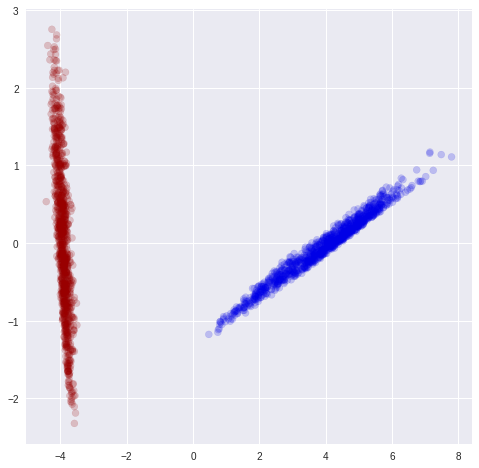

In [83]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(np.vstack((normal_features, fault_features)))

print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

red = np.array([0.6, 0, 0, 0.2])
blue = np.array([0, 0, 0.9, 0.2])

Y_label = np.append(np.zeros(1000), np.ones(1000))

clusterColor = [red * label + blue * (1 - label) for label in Y_label]

plt.figure(figsize=(8, 8))
plt.scatter(x = pca_result[:, 0], y=pca_result[:, 1], color=clusterColor)
plt.show()

Test Image Shape From A3F2P3: (1000, 5)


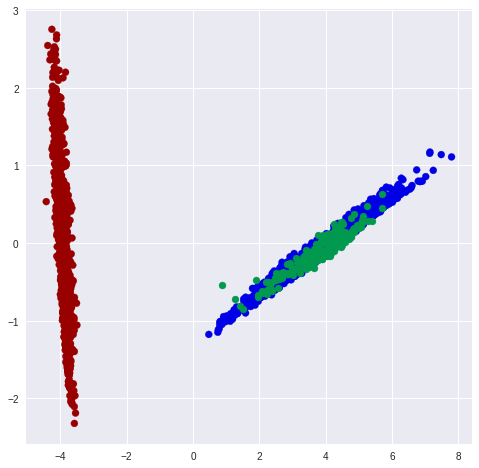

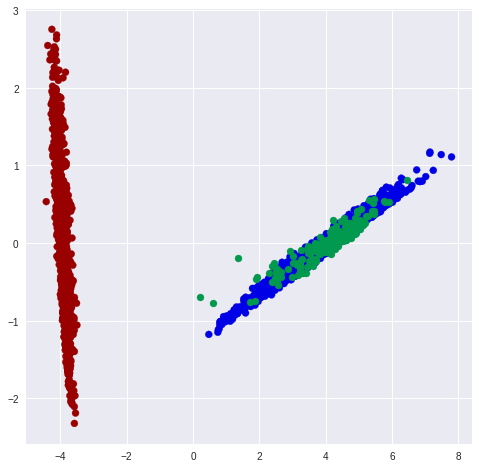

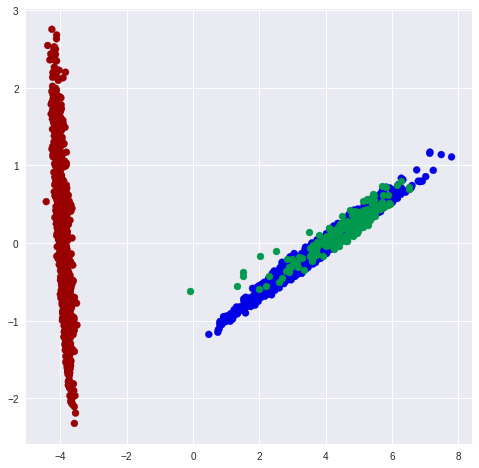

Predicted 0/3
TSNE_result Shape(1000, 2)
labelList Shape(1000, 4)
Test Image Shape From A3F3P3: (1000, 5)


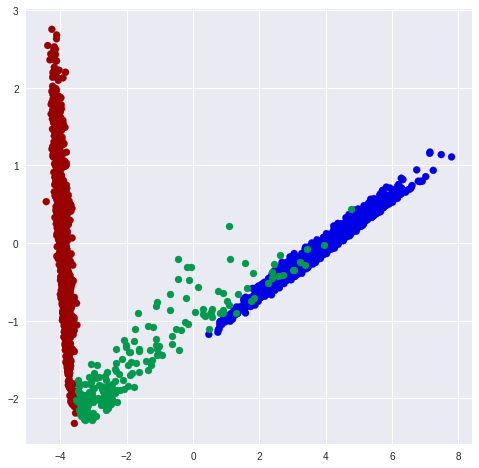

Predicted 1/3
TSNE_result Shape(2000, 2)
labelList Shape(2000, 4)
Test Image Shape From A3F4P3: (1000, 5)


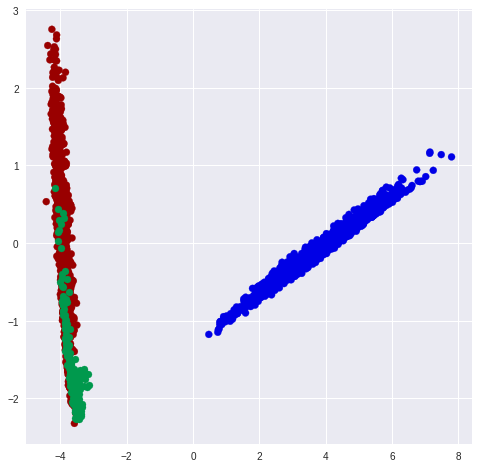

Predicted 2/3
TSNE_result Shape(3000, 2)
labelList Shape(3000, 4)


In [10]:
pathTest = list()
# folderTest = ['A3F2P3', 'A3F3P3', 'A3F4P3']
# folderTest = ['A2F3P3', 'A3F3P3', 'A4F3P3']
folderTest = ['A3F2P3', 'A3F3P3', 'A3F4P3']

for i in range(len(folderTest)):
    pathTest.append(dataPath + '/' + folderTest[i])
    

pathTests = [dataPath + '/' + folder for folder in folderTest]

startNum = 0

for i in range(startNum, len(pathTests)):

    npyTestPath = glob.glob(pathTests[i] + '/' + '*Image_With_Label.npy')
    data = np.load(npyTestPath[0])
    
    imgs = np.moveaxis(np.dstack(data[:, 0]), 2, 0)
    
    label = data[:, 1:5]
    

    
    if i == startNum:
        labelList = label
    else:
        labelList = np.vstack([labelList, label])

    print('Test Image Shape From {}: {}'.format(folderTest[i], data.shape))    

    chunkLength = 200

    for j in range(int(len(imgs) / chunkLength)):

        imgsTestChunk = imgs[j * chunkLength:(j + 1) * chunkLength, :, :]

        testImgsNorm = (imgsTestChunk - trainMean) / trainStd

        testImgsNorm = testImgsNorm.reshape(list(testImgsNorm.shape) + [1])

        X_test_ = np.stack([testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0]], axis = -1)

        intermediate_features = intermediate_layer_model.predict(X_test_)
        
#       intermediate_data = np.vstack([intermediate_features, intermediate_output])
#       intermediate_data = intermediate_features
    
#       tsne = TSNE(n_components=2, random_state=0)
#       intermediates_tsne__ = tsne._fit(intermediate_data, skip_num_points=chunkLength)
        
        TSNE_chunk = pca.transform(intermediate_features)
        
    
#       TSNE_chunk = model.predict(X_test, verbose=1)
#       TSNE_chunk = intermediates_tsne__[:200, :]
    
        plt.figure(figsize=(8, 8))
#         plt.scatter(x = intermediates_tsne__[200:600, 0], y=intermediates_tsne__[200:600, 1], color=clusterColor)
        plt.scatter(x = pca_result[:, 0], y=pca_result[:, 1], color=clusterColor)
        plt.scatter(x = TSNE_chunk[:,0], y=TSNE_chunk[:,1], color=(0, 0.6, 0.3))
#         plt.xlim([-40, 40])
#         plt.ylim([-40, 40])

#         plt.figure(figsize=(8, 8))
#         plt.scatter(x = TSNE_chunk[:,0], y=TSNE_chunk[:,1])
        plt.show()

        if j == 0:
            TSNE_result_ = TSNE_chunk
        else:
            TSNE_result_ = np.vstack((TSNE_result_, TSNE_chunk))
    
    if i == startNum:
        TSNE_result = TSNE_result_
    else:
        TSNE_result = np.vstack((TSNE_result, TSNE_result_))
        
    print('Predicted {}/{}'.format(i, len(pathTests)))    
    print('TSNE_result Shape{}'.format(TSNE_result.shape))
    print('labelList Shape{}'.format(labelList.shape))
    
    del imgs, data

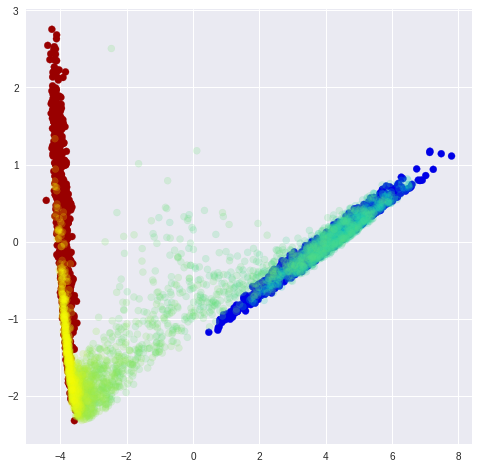

In [11]:
from operator import itemgetter

TSNE_table = np.concatenate((TSNE_result, labelList), axis = 1)

TSNE_table_sorted = np.asarray(sorted(TSNE_table, key = itemgetter(3)))

colorYellow = np.asarray([1, 1, 0, 0.2])
colorBGreen = np.asarray([0, 0.8, 0.8, 0.2])

clusterColor_ = np.asarray([colorYellow * i/len(TSNE_table_sorted) + colorBGreen * (1 - i/len(TSNE_table_sorted)) for i in range(len(TSNE_table_sorted))])

plt.figure(figsize=(8, 8))
plt.scatter(x = pca_result[:, 0], y=pca_result[:, 1], color=clusterColor)
plt.scatter(x = TSNE_table_sorted[:,0], y=TSNE_table_sorted[:,1], color=clusterColor_)

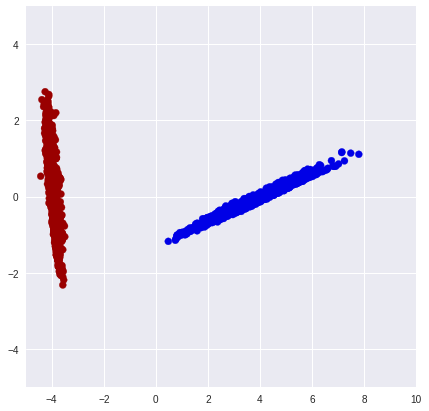

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import display, HTML

rc('animation', html='jshtml')

# Create new Figure and an Axes which fills it.
fig = plt.figure(figsize=(7, 7))
# ax = fig.add_axes([0, 0, 1, 1])
ax = fig.add_subplot(111)
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 5)
# Construct the scatter which we will update during animation
# as the raindrops develop.
x, y = [], []

scat = ax.scatter(pca_result[:, 0], pca_result[:, 1], color = np.r_[np.asarray(clusterColor), clusterColor_])


def update(frame_number):
    x = np.append(pca_result[:, 0], TSNE_table_sorted[:frame_number,0])
    y = np.append(pca_result[:, 1], TSNE_table_sorted[:frame_number,1])
    

    
    scat.set_offsets(np.c_[x, y])
    
    scat.set_color = (0.5, 0.5, 0.5)
    scat.set_facecolors = (0.5, 0.5, 0.5)
    return scat,


# Construct the animation, using the update function as the animation
# director.
animation = FuncAnimation(fig, update, frames=np.asarray(range(0, 3000, 50)), interval=100)

In [13]:
animation

In [42]:
V = np.cov(pca_result[0:1000, :].T)

mu = np.mean(pca_result[0:1000, :], axis=0)

VI = np.linalg.inv(V)

print(mu)

print(np.matmul(V, VI))

[ 3.91838    -0.05335447]
[[ 1.00000000e+00 -5.38228249e-15]
 [-7.47578776e-16  1.00000000e+00]]


In [0]:
temp = np.matmul((pca_result[0:1000, :] - mu), VI)
normalMD = [np.dot(temp[i, :], (pca_result[0:1000, :] - mu)[i, :]) for i in range(1000)]

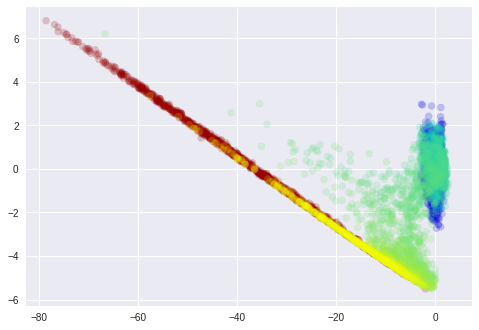

In [96]:
R = np.linalg.cholesky(VI)
temp = np.matmul((pca_result - mu), R)
temp2 = np.matmul((np.asarray(TSNE_table_sorted[:, 0:2]) - mu).astype(float), R)

plt.scatter(x = temp[:, 0],  y=temp[:, 1], color=clusterColor)
plt.scatter(x = temp2[:, 0],  y=temp2[:, 1], color=clusterColor_)

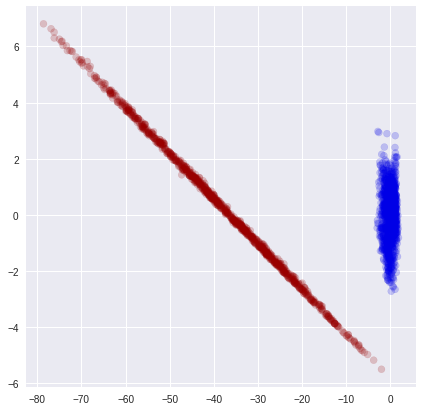

In [98]:
# Create new Figure and an Axes which fills it.
fig = plt.figure(figsize=(7, 7))
# ax = fig.add_axes([0, 0, 1, 1])
ax = fig.add_subplot(111)
# Construct the scatter which we will update during animation
# as the raindrops develop.
x, y = [], []

scat = ax.scatter(temp[:, 0], temp[:, 1], color = np.r_[np.asarray(clusterColor), clusterColor_])

def update(frame_number):
    x = np.append(temp[:, 0], temp2[:frame_number,0])
    y = np.append(temp[:, 1], temp2[:frame_number,1])
    scat.set_offsets(np.c_[x, y])

    return scat,


# Construct the animation, using the update function as the animation
# director.
animation2 = FuncAnimation(fig, update, frames=np.asarray(range(0, 3000, 50)), interval=100)

In [99]:
animation2